In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import pandas as pd

In [7]:
def bit_reverse(x, n_bits):
    return int(np.binary_repr(x, n_bits)[::-1], 2);

def correct_radix2_indexes(N):
    return [bit_reverse(i, int(np.log2(N))) for i in range(N)]

def W(k, N):
    return np.exp(-1j*(2*np.pi/N)*k)


def radix2_fft_recursive(s):
    N = len(s)
    x = [0] * N
    half = N//2
    for i in range(half):
        x[i] = s[i] + s[i+half]
        x[i+half] = (s[i] - s[i+half]) * W(i, N)
        print(N, s[i], s[i+half])
    
    if len(x) > 2:
        first = radix2_fft_recursive(x[:half])
        second = radix2_fft_recursive(x[half:])
        
        return first + second
    return x

def radix2_fft(s):
    r = radix2_fft_recursive(s)
    r = np.array(r)[correct_radix2_indexes(len(x))]
    return r

In [11]:
x = (np.random.uniform(-1, 1, 4) + np.random.uniform(-1, 1, 4)*1j) * 0.5
x = [0, 1, 2, 3]
model = fft(x)
dut = radix2_fft(x)
np.testing.assert_allclose(model, dut)

4 0 2
4 1 3
2 2 4
2 (-2+0j) (-1.2246467991473532e-16+2j)


In [6]:
x = [0.1 + 0.2j, 0.3 + 0.4j]
fft(x)

array([ 0.4+0.6j, -0.2-0.2j])

In [7]:
x[0] + x[1]

(0.2+0.4j)

In [12]:
N = 2
k = 0
n = 1
np.exp( (-2j*np.pi*k*n) /N)

(1+0j)

In [20]:
N = 8
r = np.empty(shape=(N,N))
for k in range(N):
    for n in range(N):
        r[k][n] = np.exp(-1j * 2 * np.pi * k * n / N)
        

/home/gaspar/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


In [22]:
pd.DataFrame(r)

,0,1,2,3,4,5,6,7
0,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.000000e+00,1.000000e+00,1.000000e+00
1,1.0,7.071068e-01,6.123234e-17,-7.071068e-01,-1.0,-7.071068e-01,-1.836970e-16,7.071068e-01
2,1.0,6.123234e-17,-1.000000e+00,-1.836970e-16,1.0,3.061617e-16,-1.000000e+00,-4.286264e-16
3,1.0,-7.071068e-01,-1.836970e-16,7.071068e-01,-1.0,7.071068e-01,5.510911e-16,-7.071068e-01
4,1.0,-1.000000e+00,1.000000e+00,-1.000000e+00,1.0,-1.000000e+00,1.000000e+00,-1.000000e+00
5,1.0,-7.071068e-01,3.061617e-16,7.071068e-01,-1.0,7.071068e-01,-2.694842e-15,-7.071068e-01
6,1.0,-1.836970e-16,-1.000000e+00,5.510911e-16,1.0,-2.694842e-15,-1.000000e+00,-4.904777e-16
7,1.0,7.071068e-01,-4.286264e-16,-7.071068e-01,-1.0,-7.071068e-01,-4.904777e-16,7.071068e-01


In [224]:
def W(k, N):
    return np.exp(-1j*(2*np.pi/N)*k)

def radix2_fft_hardcode(s, N=8):
    # stage 1
    
    x0 = s[0] + s[4]
    x4 = (s[0] - s[4]) * W(0, N)
    
    x1 = s[1] + s[5]
    x5 = (s[1] - s[5]) * W(1, N)
    
    x2 = s[2] + s[6]
    x6 = (s[2] - s[6]) * W(2, N)
    
    x3 = s[3] + s[7]
    x7 = (s[3] - s[7]) * W(3, N)
    print(x0, x1, x2, x3, x4, x5, x6, x7)
    
    
    # stage 2.1
    x00 = x0 + x2
    x02 = (x0 - x2) * W(0, N/2)
    
    x01 = x1 + x3
    x03 = (x1 - x3) * W(1, N/2)
    
    # stage 2.2
    x10 = x4 + x6
    x12 = (x4 - x6) * W(0, N/2)
    
    x11 = x5 + x7
    x13 = (x5 - x7) * W(1, N/2)
    
    
    # state 3.1
    x000 = x00 + x01
    x001 = (x00 - x01) * W(0, N/2/2)
    
    # stage 3.2
    x002 = x02 + x03
    x003 = (x02 - x03) * W(0, N/2/2)
    
    # state 3.3
    x004 = x10 + x11
    x005 = (x10 - x11) * W(0, N/2/2)
    
    # state 3.4
    x006 = x12 + x13
    x007 = (x12 - x13) * W(0, N/2/2)
    
    return [x000, x004, x002, x006, x001, x005, x003, x007]



In [225]:
for i, o in enumerate(radix2_fft_hardcode(x)):
    print(i, o)

0.5376636036804365 0.08659474864651462 0.09796880666431518 0.38516966581663703 (1.0992381260674762+0j) (1.2632511986980999-1.2632511986980997j) (6.711103012026774e-17-1.0960062961335963j) (0.883366964107727+0.8833669641077271j)
0 1.1073968248079034
1 (3.245856288873303-1.475890530723969j)
2 (0.43969479701612135+0.2985749171701224j)
3 (-1.0473800367383506+0.7161220615432233j)
4 (0.16386799588160006+0j)
5 (-1.0473800367383506-0.7161220615432238j)
6 (0.43969479701612135-0.2985749171701224j)
7 (3.245856288873303+1.4758905307239694j)


In [113]:
my_fft(x)

[(-1.4085892659159542+0j),
 (-0.5029561364884098+0.6938658241456137j),
 (-1.4569420591077935+0.023467566233155025j),
 (0.27679621673838484-2.25291616914042j),
 (-1.1527959119349496+4.262696068721097e-16j),
 (0.2767962167383809+2.2529161691404216j),
 (-1.4569420591077928-0.02346756623315644j),
 (-0.5029561364884113-0.6938658241456142j)]

In [219]:
x = np.random.uniform(-1, 1, 1024)

In [92]:
np.exp(-2*np.pi*1j*1024*2*2*2*2*2)

(1+8.025845262892094e-12j)

In [1]:
N = 8
t = np.arange(N) / N 
c = np.exp(-2*np.pi*1j*1*t)
print(c)

NameError: name 'np' is not defined

In [112]:
def my_fft(x, N=None):
    if N is None:
        N = len(x)
    out = []
    t = np.arange(N) / N
    for i in range(N):
#         np.exp(-2*np.pi*1j*i*t)
        binn = np.sum(x * W(i, N))
        out.append(binn)
    return out

In [84]:
np.sum(x * c)

(-0.5029561364884098+0.6938658241456137j)

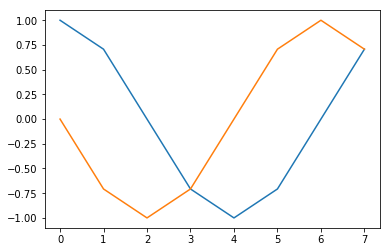

In [85]:
plt.plot(c.real)
plt.plot(c.imag)
plt.show()